# SoPaGraMi (submine) — Example Usage

This notebook demonstrates running **SoPaGraMi** via `submine` on three kinds of inputs:

1. A **single-graph `.lg`** file (native / typical SoPaGraMi input)
2. A **gSpan-style `.data`** *multi-graph* dataset (automatically transcoded to SoPaGraMi’s expected input when possible)
3. A simple **edge list** file (automatically transcoded)

It also shows a pragmatic approach to **plotting** one mined subgraph pattern (when the result object exposes a pattern graph or when the backend writes an output file that can be parsed).

> Notes  
> - SoPaGraMi mines frequent subgraphs from a **single large graph**. If you pass a multi-graph dataset (e.g., `.data`), `submine` may either reject it or convert it.  Currently, we reject it

In [1]:
# If you are running this in a fresh environment, install submine first:
# !pip install submine

import os
from pathlib import Path

## 0. Create sample input data (LG, DATA, Edge list)

### skip this if you have data

In [26]:
from pathlib import Path

work = Path("sopagrami_demo")
work.mkdir(exist_ok=True)

# --- A tiny .lg-like file ---
# Many single-graph formats accept: v <id> <label>, e <u> <v> <label>
# If your sopagrami parser expects a different .lg dialect, replace this file with your own sample.
lg_path = work / "toy.lg"
lg_path.write_text("""v 0 A
v 1 B
v 2 A
v 3 C
e 0 1 x
e 1 2 x
e 2 3 y
e 0 2 z
""")

# --- A tiny gSpan-style .data dataset with TWO graphs (transactional) ---
# This is a common gSpan encoding; submine may transcode it depending on configuration.
data_path = work / "toy.data"
data_path.write_text("""t # 0
v 0 1
v 1 2
v 2 1
e 0 1 1
e 1 2 1
t # 1
v 0 1
v 1 2
v 2 3
e 0 1 1
e 1 2 2
t # -1
""")
data_path_single = work / "toy.data"
data_path_single.write_text("""t # 0
v 0 1
v 1 2
v 2 1
e 0 1 1
e 1 2 1
v 0 1
v 1 2
v 2 3
e 0 1 1
e 1 2 2

""")
# --- A tiny undirected edge list ---
# Convention: "u v" per line. If you need weights/labels, adapt to your library's parser.
edgelist_path = work / "toy.edgelist"
edgelist_path.write_text("""0 1
1 2
2 3
0 2
""")



16

## 1. Run SoPaGraMi on `.lg` input

In [3]:
from submine.api import mine_subgraphs

out_lg = work / "out_lg"
out_lg.mkdir(exist_ok=True)

res_lg = mine_subgraphs(
    data=str(lg_path),
    algorithm="sopagrami",
    min_support=2,
    out_dir=str(out_lg),
    dump_images_csv=False,        # set True if your build supports it
    dump_sample_embeddings=False  # set True only if implemented in your version
)

type(res_lg)

submine.core.result.MiningResult

## 2. Run SoPaGraMi on `.data` input (auto-transcode when supported)

#### SoPaGrami expects a single graph so this will produce  an exception

In [4]:
out_data = work / "out_data"
out_data.mkdir(exist_ok=True)

try:
    res_data = mine_subgraphs(
        data=str(data_path),
        algorithm="sopagrami",
        min_support=2,
        out_dir=str(out_data),
    )
    print("SoPaGraMi run on .data succeeded.")
except Exception as e:
    res_data = None
    print("SoPaGraMi run on .data did not succeed in this environment.")
    print("Reason:", repr(e))

res_data

SoPaGraMi run on .data succeeded.


MiningResult(patterns=[], algorithm='sopagrami', params={'tau': 2, 'directed': False, 'sorted_seeds': True, 'num_threads': 0, 'compute_full_support': True, 'input_format': 'lg'}, runtime=0.0010159015655517578, metadata={'backend': 'sopagrami_cpp', 'input_lg': 'C:\\Users\\Amure\\AppData\\Local\\Temp\\tmpx8szrv8b\\native.lg'})

This will work!
In the future, we can modify SoPaGrami to either merge or process each graph separately

In [5]:
out_data = work / "out_data"
out_data.mkdir(exist_ok=True)

try:
    res_data = mine_subgraphs(
        data=str(data_path_single),
        algorithm="sopagrami",
        min_support=2,
        out_dir=str(out_data),
    )
    print("SoPaGraMi run on .data succeeded.")
except Exception as e:
    res_data = None
    print("SoPaGraMi run on .data did not succeed in this environment.")
    print("Reason:", repr(e))

res_data

SoPaGraMi run on .data succeeded.


MiningResult(patterns=[], algorithm='sopagrami', params={'tau': 2, 'directed': False, 'sorted_seeds': True, 'num_threads': 0, 'compute_full_support': True, 'input_format': 'lg'}, runtime=0.00199127197265625, metadata={'backend': 'sopagrami_cpp', 'input_lg': 'C:\\Users\\Amure\\AppData\\Local\\Temp\\tmpmilrzsj2\\native.lg'})

## 3. Run SoPaGraMi on an edge list (auto-transcode)

In [6]:
out_el = work / "out_edgelist"
out_el.mkdir(exist_ok=True)

res_el = mine_subgraphs(
    data=str(edgelist_path),
    algorithm="sopagrami",
    min_support=2,
    out_dir=str(out_el),
)

type(res_el)

submine.core.result.MiningResult

## 4. Inspect the result object

In [7]:
def summarize_result(obj):
    if obj is None:
        return {"type": None}
    info = {"type": type(obj).__name__}
    # common patterns: dataclass-like, dict-like, list-like
    if hasattr(obj, "__dict__"):
        info["attrs"] = sorted([k for k in obj.__dict__.keys()])[:50]
    if isinstance(obj, dict):
        info["keys"] = sorted(list(obj.keys()))[:50]
    if isinstance(obj, (list, tuple)):
        info["len"] = len(obj)
        info["first_type"] = type(obj[0]).__name__ if len(obj) else None
    return info

summarize_result(res_lg)

{'type': 'MiningResult',
 'attrs': ['algorithm', 'metadata', 'params', 'patterns', 'runtime']}

In [13]:
import pandas as pd
adj = res_lg.patterns[0].graph._adj
res_lg.patterns[0].graph.directed

False

## 5. Plot a mined subgraph pattern (best-effort)

This section tries multiple strategies:

1. If `res_lg` exposes a pattern as an edge list / adjacency, build a NetworkX graph.
2. If SoPaGraMi wrote a pattern file into `out_dir`, attempt to parse it.

Because result schemas vary by implementation, this code is intentionally defensive and introspective.


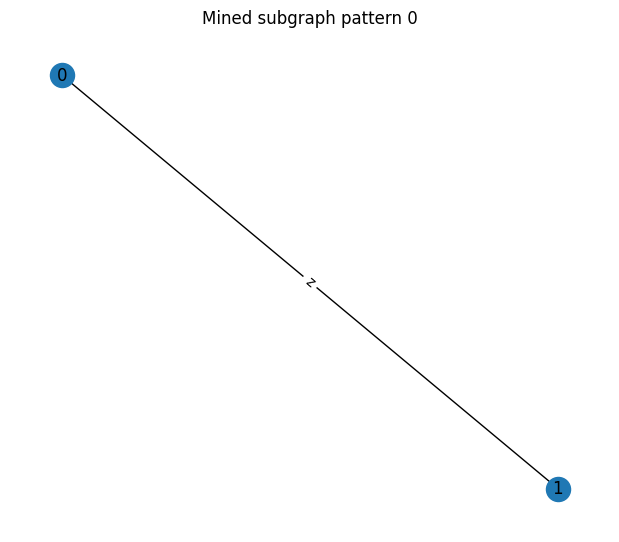

Extracted a pattern graph from the result object: 2 nodes, 1 edges


In [21]:
import networkx as nx
import matplotlib.pyplot as plt

def extract_and_plot_pattern(res,plot=True,no_of_plot=5):
    """Return a NetworkX graph if we can extract at least one pattern graph from `res`."""
    if res is None:
        return None

    graphs = []
    for idx, pattern in enumerate(res.patterns):
        g = pattern.graph
        G_pat = nx.DiGraph() if g.directed else nx.Graph()
        for u, neighbors in g._adj.items():
            for v, label, weight in neighbors:
                G_pat.add_edge(u, v, label=label, weight=weight)
        graphs.append(G_pat)
        if plot and idx<=no_of_plot:
            pos = nx.spring_layout(G_pat, seed=7)

            plt.figure(figsize=(6, 5))
            nx.draw(G_pat, pos, with_labels=True)
            edge_labels = nx.get_edge_attributes(G_pat, 'label')
            if edge_labels:
                nx.draw_networkx_edge_labels(G_pat, pos, edge_labels=edge_labels)
            title = f"Mined subgraph pattern {idx}"
            plt.title(title)
            plt.show()

    return graphs

G_pat_list = extract_and_plot_pattern(res_lg)

if G_pat_list is None:
    print("No pattern graph found directly on the result object. We'll look for output files in the out_dir next...")
else:
    print("Extracted a pattern graph from the result object:", G_pat_list[0].number_of_nodes(), "nodes,", G_pat_list[0].number_of_edges(), "edges")

In [22]:
# If your backend wrote a pattern file, you can implement a parser here.
# As a minimal fallback, we will plot the INPUT graph (toy.lg) so the notebook always plots something.

def parse_simple_lg(path: Path):
    """Parse a simple .lg dialect: v <id> <label>, e <u> <v> <label>"""
    G = nx.Graph()
    for line in Path(path).read_text().splitlines():
        line = line.strip()
        if not line:
            continue
        parts = line.split()
        if parts[0] == "v" and len(parts) >= 3:
            nid = int(parts[1]) if parts[1].isdigit() else parts[1]
            G.add_node(nid, label=parts[2])
        elif parts[0] == "e" and len(parts) >= 4:
            u = int(parts[1]) if parts[1].isdigit() else parts[1]
            v = int(parts[2]) if parts[2].isdigit() else parts[2]
            G.add_edge(u, v, label=parts[3])
    return G

if G_pat_list is None:
    G_pat = parse_simple_lg(lg_path)
    title = "input graph (toy.lg)"

    pos = nx.spring_layout(G_pat, seed=7)

    plt.figure(figsize=(6, 5))
    nx.draw(G_pat, pos, with_labels=True)
    edge_labels = nx.get_edge_attributes(G_pat, 'label')
    if edge_labels:
        nx.draw_networkx_edge_labels(G_pat, pos, edge_labels=edge_labels)
    plt.title(title)
    plt.show()

### If your data is available locally, the library can be used as follows
  


In [23]:
result =mine_subgraphs("../data/citeseer.lg", algorithm="sopagrami", 
                    min_support=15,
                    directed=True,
                    sorted_seeds=4,
                    dump_images_csv=False, #if you want to dump the images
                    dump_sample_embeddings=False, #if you want to dump the embeddings, not implemented yet
                    out_dir= None # /path/to/dir to save the images and embeddings default is ./sopagrami_result
                    )
print(result)


MiningResult(patterns=[SubgraphPattern(pid=0, graph=Graph(num_nodes=2, num_edges=1, weighted=False), support=63, frequency=None, occurrences=[], attributes={'key': 'V:1|1|E:0-1-1-80|', 'k': 2, 'num_edges': 1}), SubgraphPattern(pid=1, graph=Graph(num_nodes=2, num_edges=1, weighted=False), support=54, frequency=None, occurrences=[], attributes={'key': 'V:1|1|E:0-1-1-83|', 'k': 2, 'num_edges': 1}), SubgraphPattern(pid=2, graph=Graph(num_nodes=2, num_edges=1, weighted=False), support=51, frequency=None, occurrences=[], attributes={'key': 'V:0|0|E:0-1-1-80|', 'k': 2, 'num_edges': 1}), SubgraphPattern(pid=3, graph=Graph(num_nodes=2, num_edges=1, weighted=False), support=49, frequency=None, occurrences=[], attributes={'key': 'V:1|1|E:0-1-1-77|', 'k': 2, 'num_edges': 1}), SubgraphPattern(pid=4, graph=Graph(num_nodes=2, num_edges=1, weighted=False), support=47, frequency=None, occurrences=[], attributes={'key': 'V:1|1|E:0-1-1-85|', 'k': 2, 'num_edges': 1}), SubgraphPattern(pid=5, graph=Graph(nu

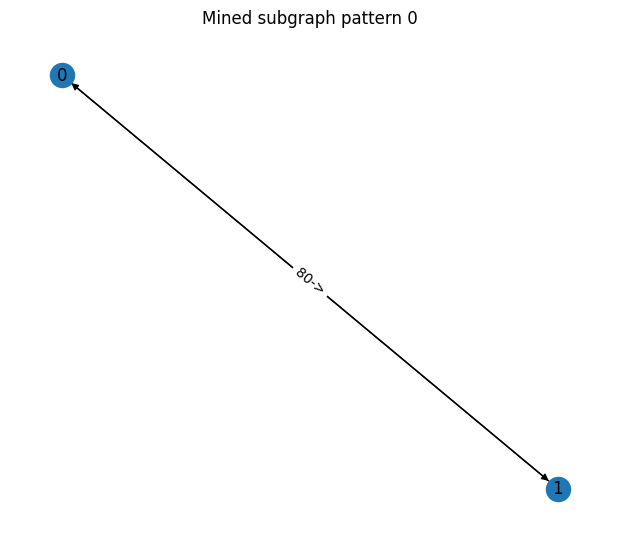

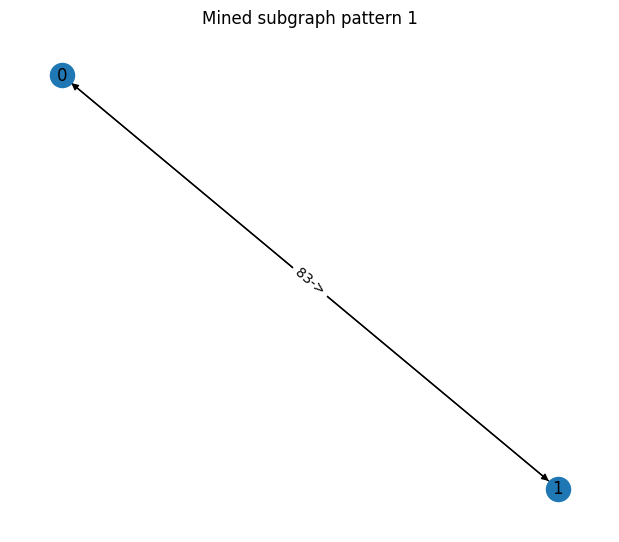

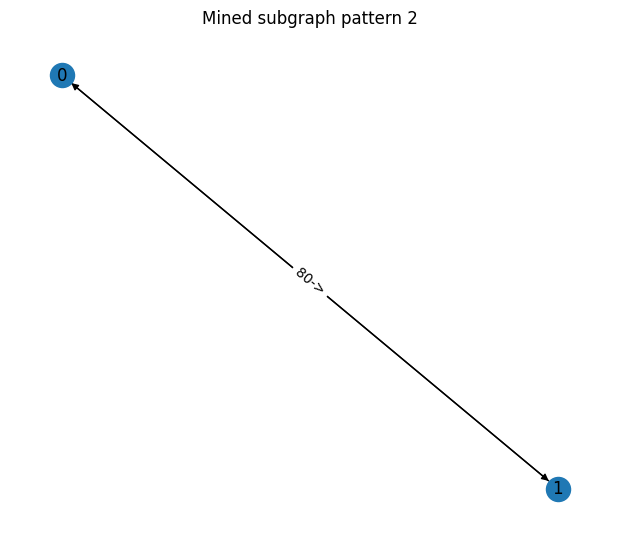

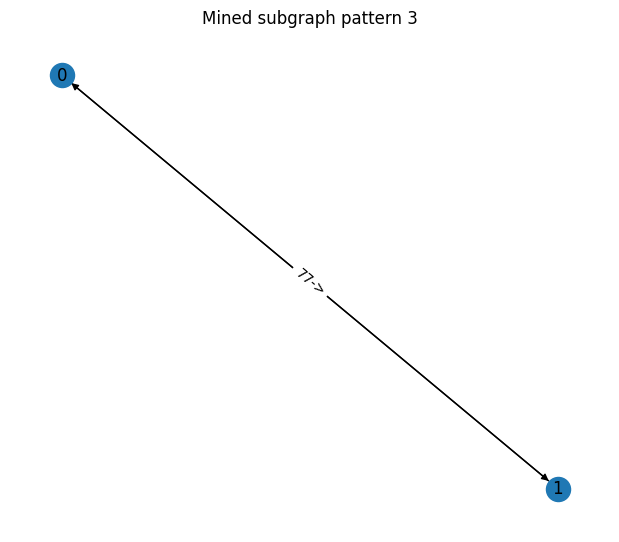

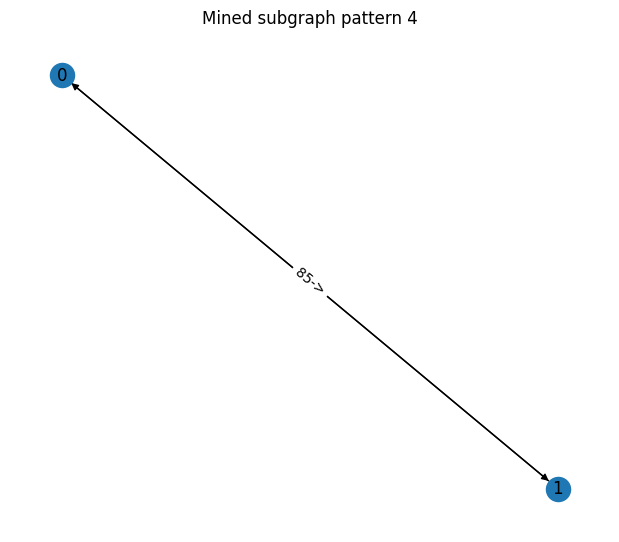

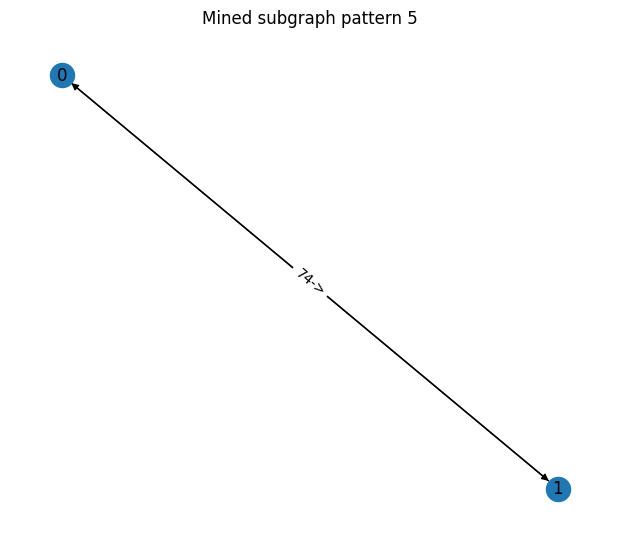

In [25]:
G_pat = extract_and_plot_pattern(result,no_of_plot=5)